# Google Colab: Access Webcam for Images and Video

Disclaimer: Part of this code is based on The AI guy on Youtube code.

This notebook will go through how to access and run code on images and video taken using your webcam.  

For this purpose of this tutorial we will be using OpenCV's Haar Cascade to do face detection on our Webcam image and video.

In [39]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import os
from PIL import Image
from google.colab.patches import cv2_imshow

In [40]:
# cloning GitHub Repository
!rm -r tandemrace
!git clone https://github.com/DLAVproject/tandemrace
repo_path = os.getcwd() + '/tandemrace'
drive_path = '/content/drive/MyDrive/'

rm: cannot remove 'tandemrace': No such file or directory
Cloning into 'tandemrace'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 27 (delta 7), reused 6 (delta 2), pack-reused 0
Unpacking objects: 100% (27/27), done.


In [41]:
# cloning yolov5 library and finishing setup
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

Cloning into 'yolov5'...
remote: Enumerating objects: 12857, done.
remote: Total 12857 (delta 0), reused 0 (delta 0), pack-reused 12857
Receiving objects: 100% (12857/12857), 11.77 MiB | 22.69 MiB/s, done.
Resolving deltas: 100% (8932/8932), done.
/content/yolov5/yolov5/yolov5/yolov5/yolov5


In [42]:
import torch
from yolov5 import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v6.1-135-g7926afc torch 1.10.0+cu111 CPU


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 39.7/107.7 GB disk)


In [43]:
# connecting to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Helper Functions
Below are a few helper function to make converting between different image data types and formats. 

In [44]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

##Yolov5 object detector
This notebook uses the YOLOv5 to detect objects in real-time.

In [76]:
# loading the model
model = torch.hub.load('ultralytics/yolov5', 'yolov5n')

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...

requirements: 1 package updated per /content/yolov5/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 v6.1-135-g7926afc torch 1.10.0+cu111 CPU



  0%|          | 0.00/3.87M [00:00<?, ?B/s]

Fusing layers... 
YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients, 4.5 GFLOPs
Adding AutoShape... 


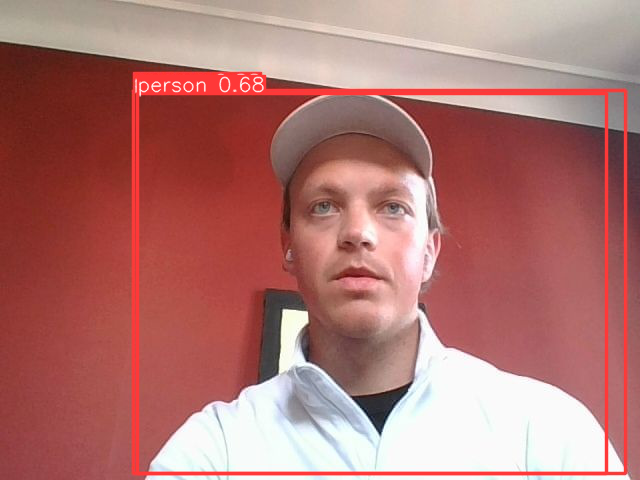

In [77]:
# demonstration of how the yolov5 object detector works

# image to run interference on:
img = Image.open('/content/drive/MyDrive/photo.jpg')

# result
model.classes=[0]
results = model(img)
results.show()

#results.show()
cv2_imshow(results.imgs[0][..., ::-1])

## Webcam Images
Running code on images taken from webcam is fairly straight-forward. We will utilize code within Google Colab's **Code Snippets** that has a variety of useful code functions to perform various tasks.

We will be using the code snippet for **Camera Capture** to utilize your computer's webcam.

In [83]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display.display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)[..., ::-1]

  # running the model
  results = model(img)
  results.show()
  # saving image
  img = results.imgs[0][..., ::-1]

  labels, cord_thres = results.xyxyn[0][:, -1].numpy(), results.xyxyn[0][:, :-1].numpy()

  return img, labels, cord_thres

<IPython.core.display.Javascript object>

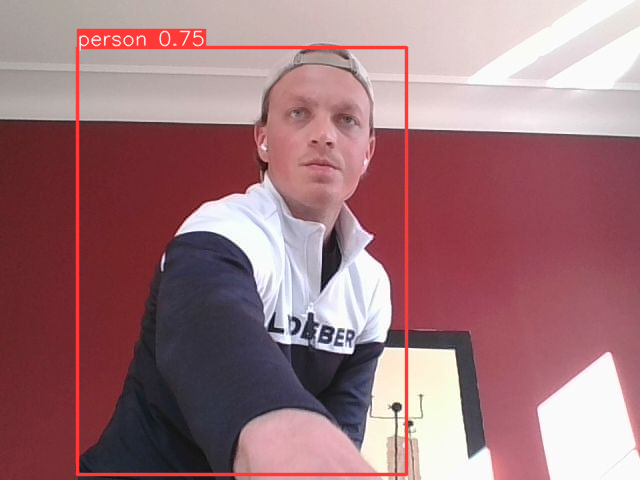

In [86]:
img, labels, cord_thres = take_photo('photo.jpg')
# Show the image which was just taken.
cv2_imshow(img)


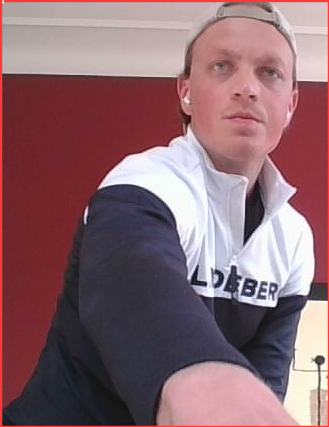

In [101]:
# cropping out the boundary box for action recognition
# TODO: Add support for more objects, simple for loop
x_shape, y_shape = 640, 480
x1, x2, y1, y2 = int(cord_thres[0][0]*x_shape), int(cord_thres[0][2]*x_shape), int(cord_thres[0][1]*y_shape), int(cord_thres[0][3]*y_shape)
img_cropped = img[y1:y2, x1:x2,:]

cv2_imshow(img_cropped)

In [ ]:
# code for action recognition should go here

## Webcam Videos
Running code on webcam video is a little more complex than images. We need to start a video stream using our webcam as input. Then we run each frame through our progam (face detection) and create an overlay image that contains bounding box of detection(s). We then overlay the bounding box image back onto the next frame of our video stream.

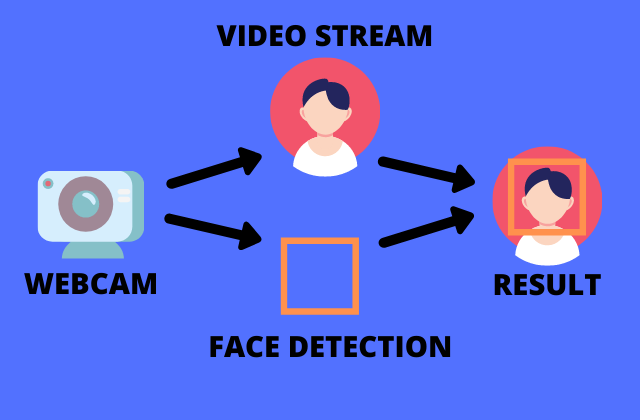</center>

In [80]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display.display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [82]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])[..., ::-1]

    #code
    #code
    results = model(img)
    labels, cord_thres = results.xyxyn[0][:, -1].numpy(), results.xyxyn[0][:, :-1].numpy()
    
    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)
    n = len(labels)
    x_shape, y_shape = 640, 480
    for i in range(n):
        row = cord_thres[i]
        if row[4] >= 0.2:
            x1, y1, x2, y2 = int(row[0]*x_shape), int(row[1]*y_shape), int(row[2]*x_shape), int(row[3]*y_shape)
            bgr = (0, 255, 0)
            # adding bounding box for the person
            bbox_array = cv2.rectangle(bbox_array, (x1, y1), (x2, y2), bgr, 2)
            # adding text with class and confidence score
            cv2.putText(bbox_array, 'Person: %.2f'%(row[4]), (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.9, bgr, 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

## Hope You Enjoyed!
If you enjoyed the tutorial and want to see more videos or tutorials check out my YouTube channel [HERE](https://www.youtube.com/channel/UCrydcKaojc44XnuXrfhlV8Q?sub_confirmation=1)

Have a great day!